In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli

from Code import ULA
from Code import Algo1
from Code import ZVnbrosse

In [13]:
import importlib
importlib.reload(Algo1)

<module 'Code.Algo1' from '/home/yerlan.turashev/Paper/VR-MCMC/Code/Algo1.py'>

In [2]:
def r(theta, x):
    return np.exp(theta.T @ x)/(1+np.exp(theta.T @ x))

def generate_data(p, n):
    X = np.empty((n,p))
    Y = np.empty(n)
    for i in range(n):
        prob = multivariate_normal.rvs(0,1,p)
        X[i, prob < 0] = -1
        X[i, prob >= 0] = +1
        X[i] = X[i]/np.linalg.norm(X[i])
        Y[i] = bernoulli.rvs(r(np.ones(p),X[i].reshape(p,1)))
    return X,Y
def sigma(X):
    n = X.shape[0]
    p = X.shape[1]
    S = np.zeros((p,p))
    for i in range(n):
        S = S + X[i].reshape((p,1)) @ X[i].reshape(1,p)
    return S 

def MLE(X,Y,Sigma):
    n = X.shape[0]
    p = X.shape[1]
    lambda_c = 3*p / np.pi**2
    eps = 1e-6
    mu = np.max(np.linalg.eigvals(Sigma))
    M = (lambda_c + 0.25*n) * mu
    theta_k =[]
    theta_k.append(np.ones((p)))
    theta_k.append(theta_k[0] - 1/(2*M) * f_grad(theta_k[0]))
    i = 2
    while(np.linalg.norm(theta_k[i-1] - theta_k[i-2])**2 > eps**2):
        theta_k.append(theta_k[i-1] - 1/(2*M) * f_grad(theta_k[i-1]))
        i = i+1
    return theta_k[-1]   

def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [3]:
def f_grad(theta):
    n = X_reg.shape[0]
    p = X_reg.shape[1]
    lambda_c = 3*p / np.pi**2
    LOG = np.zeros((p))
    for i in range(n):
        LOG = LOG + X_reg[i].reshape((p)) / (1+np.exp(theta.T @ X_reg[i].reshape((p))))
    F = X_reg.T @ Y_reg - LOG + lambda_c * Sigma @ theta
    return F

In [4]:
f_target = 'sum'

In [11]:
dim = 2
h = 0.01
n = 1000
N_train = 100
N_test = 50
deg = 1

np.random.seed(55)
X_reg, Y_reg = generate_data(dim,100)
Sigma = sigma(X_reg)

In [7]:
MLE(X_reg,Y_reg,Sigma).sum()

-0.5910956120580403

In [7]:
# def f_grad(theta):
#     n = X_reg.shape[0]
#     p = X_reg.shape[1]
#     lambda_c = 3*p / np.pi**2
#     tmp = np.exp(X_reg @ theta)
#     LOG = X_reg.T @ np.divide(tmp, 1+tmp)
#     F = X_reg.T @ Y_reg - LOG + lambda_c * Sigma @ theta
#     return F

In [8]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=100000,f_grad=f_grad)

expectation =  -0.594311655356027


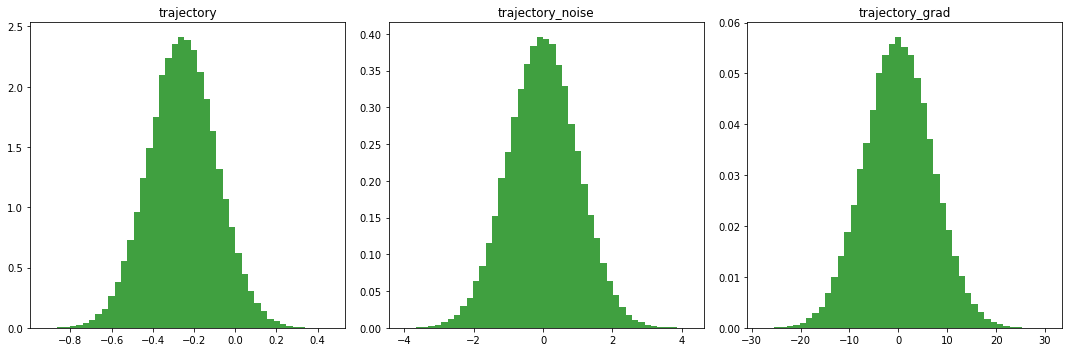

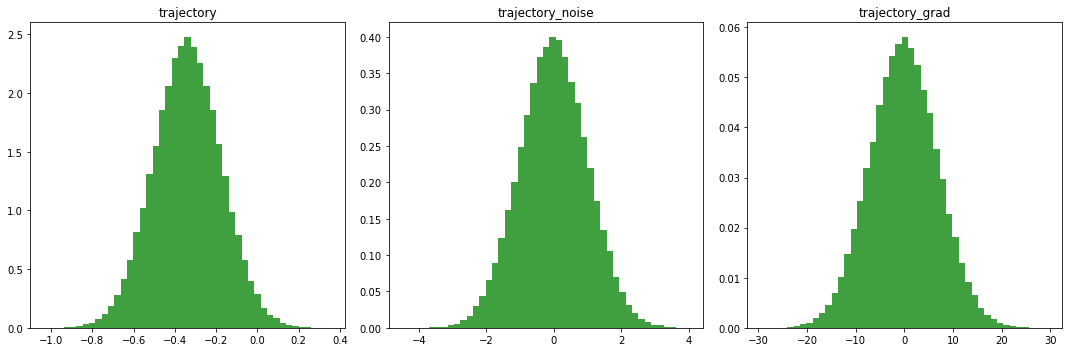

In [9]:
print ('expectation = ',local_weighted_estimator(X))
ULA.plot_distr(X,Z,G,0)
ULA.plot_distr(X,Z,G,1)

In [10]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad)
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

In [15]:
Betas, degrees = Algo1.G_pml_fit_mean(XX,max_deg = deg)

100%|██████████| 1000/1000 [00:03<00:00, 276.47it/s]


In [16]:
k_comb = np.zeros((dim,dim), dtype=np.int16)
for i in range(dim):
    k_comb[i,i] = 1

# k_comb = np.array([[1,0], [0,1], [1,1], [2,0], [0,2]], dtype=np.int16)

In [18]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], h, degrees,Betas, 50)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.5911235435686538
            (k = [1 0]) = -0.593400479951843 [Time:4.465063185999952]
            (k = [0 1]) = -0.5909902206684103 [Time:8.89719103099992]


In [32]:
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[-1])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - Algo1.M_bias(k_comb[i],XX_test[-1],GG_test[-1], ZZ_test[-1], h, degrees,Betas, n_tilde)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.5890841338221576
            (k = [1 0]) = -0.5805005732469192 [Time:2.174273637996521]
            (k = [0 1]) = -0.5918980429909466 [Time:4.300053790000675]
            (k = [1 1]) = -0.5918353597068223 [Time:6.100885476000258]
            (k = [2 0]) = -0.5920185417207232 [Time:9.85388205399795]
            (k = [0 2]) = -0.5920557654568318 [Time:13.65435997199529]


In [19]:
P_test = estimator(XX_test)

100%|██████████| 50/50 [00:00<00:00, 20698.30it/s]


In [21]:
res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVnbrosse.ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_2 = np.array(res_cv_2).reshape(-1)

In [22]:
def save_plot(M_test, n_tilde):
    all_data = [P_test]
    all_data.append(P_test - M_test.sum(axis = 0))
    all_data.append(res_zv_1)
    all_data.append(res_cv_1)
        
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,5), ('O', 'CV_B', 'ZV', 'CV'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/BLR_{}d_violin_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

    all_data.append(res_zv_2)
    all_data.append(res_cv_2)
    plt.figure(figsize=(10,10))
    plt.violinplot(all_data, showmeans=True, showmedians=False)
    plt.xticks(np.arange(1,7), ('O', 'CV_B', 'ZV-1', 'CV-1', 'ZV-2', 'CV-2'))
    plt.tick_params(labelsize = 15)
    plt.grid()
    plt.savefig("Algo1_logs/BLR_{}d_violin_full_(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).png".format(dim, h, n, n_tilde,f_target))

In [31]:
# for n_tilde in [60, 80, 100, 150, 200]:
#     M_test = np.empty((len(k_comb),P_test.shape[0]))
#     for i in range(len(k_comb)):
#         M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas, n_tilde, n_jobs=8)
#     save_plot(M_test, n_tilde)
#     np.save("Algo1_logs/BLR_{}d_M_test(h = {}, n = {}, K = 1, n_tilde={}, f_target = {}).npy".
#             format(dim, h, n, n_tilde,f_target), M_test)
#     print("plots_saved for n_tilde = {}".format(n_tilde))

In [34]:
M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = Algo1.estimator_bias(k_comb[i], XX_test, GG_test, ZZ_test, h, degrees,Betas, n_tilde, n_jobs=2)

100%|██████████| 50/50 [00:00<00:00, 14187.20it/s]


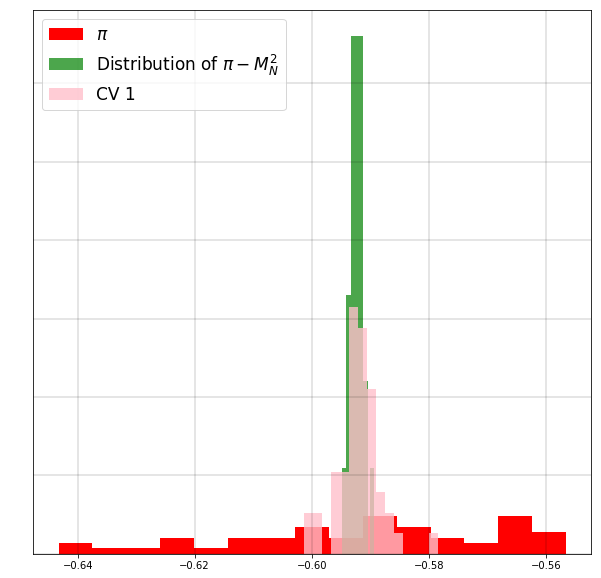

In [26]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.7, label="Distribution of $\pi - M^2_N$")

# plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.8, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.8, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.8, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.8, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
# plt.xlim(-1.339, -1.338)
plt.show()

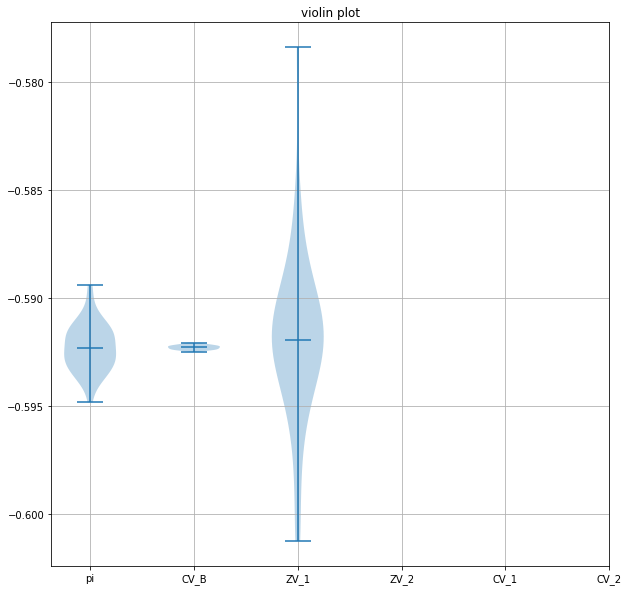

In [27]:
all_data = []
all_data.append(P_test - M_test.sum(axis = 0))
all_data.append(res_zv_1)
# all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,7), ('pi', 'CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

In [28]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test[:i+1].sum(axis = 0)).var(ddof = 1))
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.0005204546486480624
Variance of new estimator = 0.00020730292970671754
Variance of new estimator = 1.2234764735177787e-06
        Variance of CV 1 =  1.4571408043716532e-05
        Variance of CV 2 =  2.3551643411212844e-10
        Variance of ZV 1 =  1.1061408001569152e-08
        Variance of ZV 2 =  2.3494401422465473e-10


In [29]:
print ('VRF CVB = ',P_test.var(ddof = 1)/ (P_test - M_test.sum(axis = 0)).var(ddof=1))
print ('VRF CV1 = ',P_test.var(ddof = 1)/res_cv_1.var(ddof = 1))
print ('VRF CV2 = ',P_test.var(ddof = 1)/res_cv_2.var(ddof = 1))
print ('VRF ZV1 = ',P_test.var(ddof = 1)/res_zv_1.var(ddof = 1))
print ('VRF ZV2 = ',P_test.var(ddof = 1)/res_zv_2.var(ddof = 1))

VRF CVB =  425.38999311661024
VRF CV1 =  35.71752620519692
VRF CV2 =  2209844.296471795
VRF ZV1 =  47051.392424385
VRF ZV2 =  2215228.3826665226


In [45]:
# np.save("logs/BLR_2d_M_test_(K = {}, n_tilde={}).npy".format(deg, n_tilde), M_test)